  # Projet de Modélisation Supervisée : Prédiction du Statut des Réservations

## Contexte

Une entreprise de transport (type Uber/Bolt) rencontre des pertes importantes à cause de réservations annulées, incomplètes ou sans chauffeur disponible.  
L'objectif est de prédire à l'avance si une réservation sera complétée ou non, en fonction des caractéristiques du trajet, afin de réduire les pertes et améliorer la satisfaction client.

## Problématique Métier

Comment prédire le statut d'une réservation (`Completed` ou `Not Completed`) en utilisant les informations disponibles sur la course : type de véhicule, distance, localisation, méthode de paiement, notes des clients et des chauffeurs, etc. ?

## Parties Prenantes

- **Direction de l’entreprise** : souhaite réduire les pertes financières liées aux annulations.  
- **Équipe opérationnelle** : souhaite comprendre les causes principales des annulations pour ajuster la planification des chauffeurs.  
- **Clients et chauffeurs** : bénéficient d’une meilleure expérience grâce à moins d’annulations surprises.

## Objectifs du Projet

1. Explorer et nettoyer le dataset pour préparer les données.  
2. Construire un modèle de classification supervisé pour prédire le statut d’une réservation.  
3. Interpréter les résultats pour identifier les facteurs influençant les annulations.  
4. Analyser les raisons textuelles des annulations à l’aide de NLP.  
5. Estimer la valeur des réservations complétées via un modèle de régression.

## Plan de Travail

1. Préparation des données (nettoyage, encodage, création de variables).  
2. Exploration des données (EDA) et visualisations.  
3. Modélisation supervisée (Random Forest, XGBoost, etc.).  
4. Évaluation des modèles (accuracy, F1-score, confusion matrix).  
5. Interprétation des résultats (SHAP).  
6. Conclusion et recommandations business.


# 1. Chargement du Dataset et Aperçu des Données

Dans cette section, nous allons :  
- Charger le fichier CSV contenant les réservations.  
- Afficher les premières lignes pour comprendre la structure des données.  
- Identifier les colonnes et les types de données.  
- Vérifier la présence de valeurs manquantes.


In [12]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
#from sklearn.impute import SimpleImputer
import shap

# Charger le dataset
df = pd.read_csv("ncr_ride_bookings.csv")

# Afficher un aperçu des 5 premières lignes
df.head()

#Copier le dataset original pour ne pas perdre les données brutes
df.copy()

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Reason for cancelling by Customer,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method
0,2024-03-23,12:29:38,"""CNR5884300""",No Driver Found,"""CID1982111""",eBike,Palam Vihar,Jhilmil,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-11-29,18:01:39,"""CNR1326809""",Incomplete,"""CID4604802""",Go Sedan,Shastri Nagar,Gurgaon Sector 56,4.9,14.0,...,NaN,NaN,NaN,1.0,Vehicle Breakdown,237.0,5.73,NaN,NaN,UPI
2,2024-08-23,08:56:10,"""CNR8494506""",Completed,"""CID9202816""",Auto,Khandsa,Malviya Nagar,13.4,25.8,...,NaN,NaN,NaN,NaN,NaN,627.0,13.58,4.9,4.9,Debit Card
3,2024-10-21,17:17:25,"""CNR8906825""",Completed,"""CID2610914""",Premier Sedan,Central Secretariat,Inderlok,13.1,28.5,...,NaN,NaN,NaN,NaN,NaN,416.0,34.02,4.6,5.0,UPI
4,2024-09-16,22:08:00,"""CNR1950162""",Completed,"""CID9933542""",Bike,Ghitorni Village,Khan Market,5.3,19.6,...,NaN,NaN,NaN,NaN,NaN,737.0,48.21,4.1,4.3,UPI
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149995,2024-11-11,19:34:01,"""CNR6500631""",Completed,"""CID4337371""",Go Mini,MG Road,Ghitorni,10.2,44.4,...,NaN,NaN,NaN,NaN,NaN,475.0,40.08,3.7,4.1,Uber Wallet
149996,2024-11-24,15:55:09,"""CNR2468611""",Completed,"""CID2325623""",Go Mini,Golf Course Road,Akshardham,5.1,30.8,...,NaN,NaN,NaN,NaN,NaN,1093.0,21.31,4.8,5.0,UPI
149997,2024-09-18,10:55:15,"""CNR6358306""",Completed,"""CID9925486""",Go Sedan,Satguru Ram Singh Marg,Jor Bagh,2.7,23.4,...,NaN,NaN,NaN,NaN,NaN,852.0,15.93,3.9,4.4,Cash
149998,2024-10-05,07:53:34,"""CNR3030099""",Completed,"""CID9415487""",Auto,Ghaziabad,Saidulajab,6.9,39.6,...,NaN,NaN,NaN,NaN,NaN,333.0,45.54,4.1,3.7,UPI


In [13]:
# Informations sur le dataset : colonnes, types de données, valeurs non nulles
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Date                               150000 non-null  object 
 1   Time                               150000 non-null  object 
 2   Booking ID                         150000 non-null  object 
 3   Booking Status                     150000 non-null  object 
 4   Customer ID                        150000 non-null  object 
 5   Vehicle Type                       150000 non-null  object 
 6   Pickup Location                    150000 non-null  object 
 7   Drop Location                      150000 non-null  object 
 8   Avg VTAT                           139500 non-null  float64
 9   Avg CTAT                           102000 non-null  float64
 10  Cancelled Rides by Customer        10500 non-null   float64
 11  Reason for cancelling by Customer  1050

In [14]:
# Vérifier le nombre de valeurs manquantes par colonne
df.isnull().sum()


Date                                      0
Time                                      0
Booking ID                                0
Booking Status                            0
Customer ID                               0
Vehicle Type                              0
Pickup Location                           0
Drop Location                             0
Avg VTAT                              10500
Avg CTAT                              48000
Cancelled Rides by Customer          139500
Reason for cancelling by Customer    139500
Cancelled Rides by Driver            123000
Driver Cancellation Reason           123000
Incomplete Rides                     141000
Incomplete Rides Reason              141000
Booking Value                         48000
Ride Distance                         48000
Driver Ratings                        57000
Customer Rating                       57000
Payment Method                        48000
dtype: int64

In [15]:
# Statistiques descriptives des colonnes numériques
df.describe()


,Avg VTAT,Avg CTAT,Cancelled Rides by Customer,Cancelled Rides by Driver,Incomplete Rides,Booking Value,Ride Distance,Driver Ratings,Customer Rating
count,139500.000000,102000.000000,10500.0,27000.0,9000.0,102000.000000,102000.000000,93000.000000,93000.000000
mean,8.456352,29.149636,1.0,1.0,1.0,508.295912,24.637012,4.230992,4.404584
std,3.773564,8.902577,0.0,0.0,0.0,395.805774,14.002138,0.436871,0.437819
min,2.000000,10.000000,1.0,1.0,1.0,50.000000,1.000000,3.000000,3.000000
25%,5.300000,21.600000,1.0,1.0,1.0,234.000000,12.460000,4.100000,4.200000
50%,8.300000,28.800000,1.0,1.0,1.0,414.000000,23.720000,4.300000,4.500000
75%,11.300000,36.800000,1.0,1.0,1.0,689.000000,36.820000,4.600000,4.800000
max,20.000000,45.000000,1.0,1.0,1.0,4277.000000,50.000000,5.000000,5.000000


# 2. Préparation et Nettoyage des Données

Dans cette section, nous allons :  
- Nettoyer les valeurs manquantes.  
- Encoder les variables catégorielles.  
- Créer la variable cible binaire `Booking_Status_Binary`.  
- Préparer les données pour la modélisation.


In [16]:
#Gestion des valeurs manquantes

In [17]:
# Colonnes numériques
numeric_cols = ['Ride Distance', 'Booking Value', 'Driver Ratings', 'Customer Rating']

# # Remplacer les NaN par la médiane
# for col in numeric_cols:
#df[col] = df[col].fillna(data[col].median())


In [26]:
# Colonnes numériques liées aux annulations/incompletes
num_cols = ['Cancelled Rides by Driver', 'Incomplete Rides']
for col in num_cols:
    df[col] = df[col].fillna(0)

# Colonnes textuelles liées aux raisons
text_cols = ['Driver Cancellation Reason', 'Incomplete Rides Reason']
for col in text_cols:
    df[col] = df[col].fillna('Unknown')


In [27]:

# Vérifier qu'il ne reste plus de valeurs manquantes
df[text_cols + num_cols].isnull().sum()



Driver Cancellation Reason    0
Incomplete Rides Reason       0
Cancelled Rides by Driver     0
Incomplete Rides              0
dtype: int64

Création de la cible binaire

In [29]:

# Copier le dataset pour sécurité
model_data = df.copy()
# Créer la cible binaire
model_data['Booking_Status_Binary'] = model_data['Booking Status'].apply(lambda x: 1 if x == 'Completed' else 0)
# Identifier les colonnes non numériques
categorical_cols = model_data.select_dtypes(include=['object']).columns

# Numériques → median
num_cols = model_data.select_dtypes(include=['int64','float64']).columns
model_data[num_cols] = model_data[num_cols].fillna(model_data[num_cols].median())

# Catégorielles → "Unknown"
cat_cols = model_data.select_dtypes(include=['object']).columns
model_data[cat_cols] = model_data[cat_cols].fillna("Unknown")

# Encoder toutes les colonnes catégorielles
le = LabelEncoder()
for col in categorical_cols:
    model_data[col] = le.fit_transform(model_data[col].astype(str))

# Vérification finale
print(model_data.dtypes)
model_data.head()


Date                                   int32
Time                                   int32
Booking ID                             int32
Booking Status                         int32
Customer ID                            int32
Vehicle Type                           int32
Pickup Location                        int32
Drop Location                          int32
Avg VTAT                             float64
Avg CTAT                             float64
Cancelled Rides by Customer          float64
Reason for cancelling by Customer      int32
Cancelled Rides by Driver            float64
Driver Cancellation Reason             int32
Incomplete Rides                     float64
Incomplete Rides Reason                int32
Booking Value                        float64
Ride Distance                        float64
Driver Ratings                       float64
Customer Rating                      float64
Payment Method                         int32
Booking_Status_Binary                  int64
dtype: obj

,Date,Time,Booking ID,Booking Status,Customer ID,Vehicle Type,Pickup Location,Drop Location,Avg VTAT,Avg CTAT,...,Cancelled Rides by Driver,Driver Cancellation Reason,Incomplete Rides,Incomplete Rides Reason,Booking Value,Ride Distance,Driver Ratings,Customer Rating,Payment Method,Booking_Status_Binary
0,82,27223,80398,4,16198,6,116,68,8.3,28.8,...,0.0,4,0.0,2,414.0,23.72,4.3,4.5,5,0
1,333,44812,5340,3,59522,3,149,47,4.9,14.0,...,0.0,4,1.0,3,237.0,5.73,4.3,4.5,3,0
2,235,15712,123807,2,135726,0,80,90,13.4,25.8,...,0.0,4,0.0,2,627.0,13.58,4.9,4.9,2,1
3,294,42274,130594,2,26449,4,21,60,13.1,28.5,...,0.0,4,0.0,2,416.0,34.02,4.6,5.0,3,1
4,259,58545,15756,2,147677,1,39,79,5.3,19.6,...,0.0,4,0.0,2,737.0,48.21,4.1,4.3,3,1


# 3. Exploration des Données (EDA)

L'objectif de cette étape est de :  
- Comprendre la distribution des statuts de réservation.  
- Identifier les facteurs qui influencent les annulations ou courses incomplètes.  
- Examiner les relations entre les variables numériques et la cible.  
- Visualiser les corrélations entre les features.


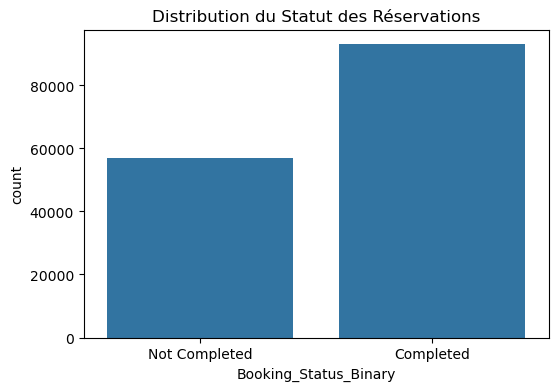

In [30]:
# Distribution Booking_Status_Binary
plt.figure(figsize=(6,4))
sns.countplot(x='Booking_Status_Binary', data=model_data)
plt.xticks([0,1], ['Not Completed', 'Completed'])
plt.title("Distribution du Statut des Réservations")
plt.savefig('cible.png')
plt.show()

In [31]:
#Analyse des variables catégorielles

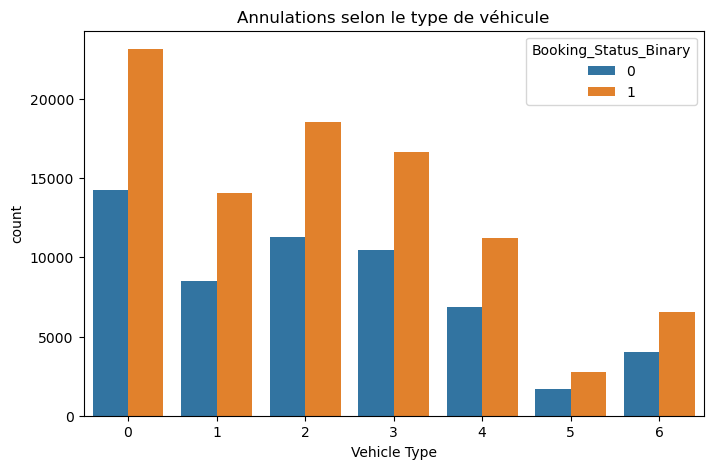

In [32]:
# Exemple : Vehicle Type vs Statut de réservation
plt.figure(figsize=(8,5))
sns.countplot(x='Vehicle Type', hue='Booking_Status_Binary', data=model_data)
plt.title("Annulations selon le type de véhicule")
plt.show()


In [33]:
#Analyse des variables numériques

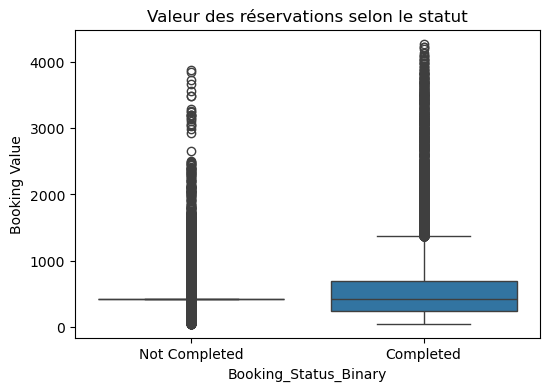

In [34]:
# Boxplot Booking Value vs Statut de réservation
plt.figure(figsize=(6,4))
sns.boxplot(x='Booking_Status_Binary', y='Booking Value', data=model_data)
plt.xticks([0,1], ['Not Completed', 'Completed'])
plt.title("Valeur des réservations selon le statut")
plt.show()

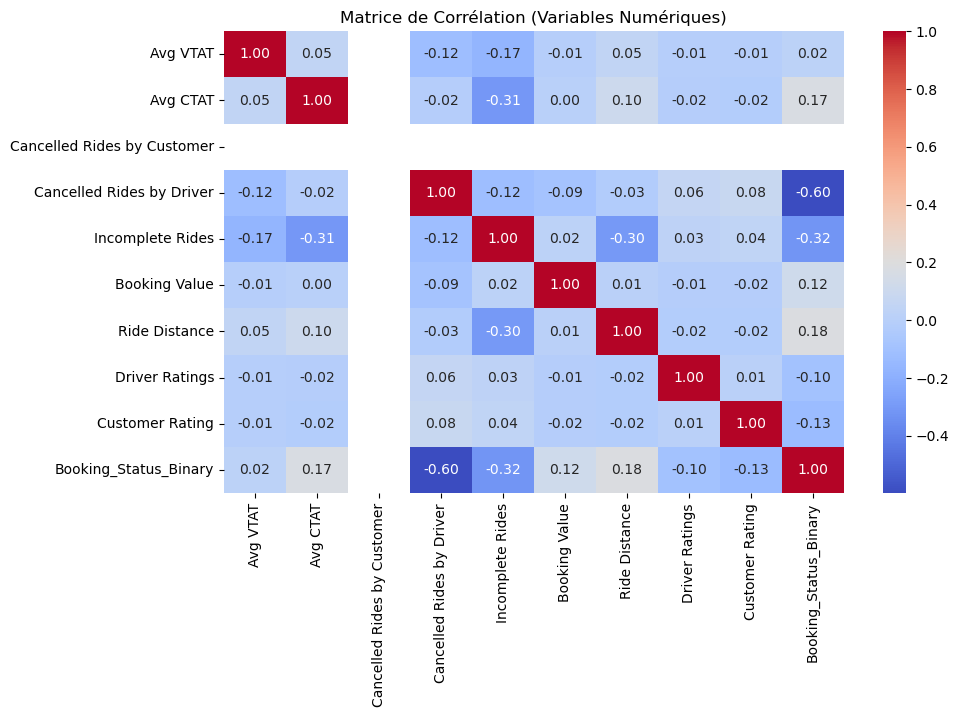

In [35]:
# Sélectionner uniquement les colonnes numériques
numeric_data = model_data.select_dtypes(include=['int64','float64'])

# Matrice de corrélation
plt.figure(figsize=(10,6))
sns.heatmap(numeric_data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Matrice de Corrélation (Variables Numériques)")
plt.show()



5. Modélisation : Random Forest & XGBoost

Objectifs :
- Séparer les données en train/test.
- Entraîner deux modèles (Random Forest et XGBoost).
- Comparer leurs performances avec des métriques : Accuracy, Precision, Recall, F1-score.
- Interpréter les features importantes.

In [36]:
df['Booking Status'] = df['Booking Status'].str.strip().str.title()
model_data['Booking_Status_Binary'] = df['Booking Status'].apply(lambda x: 1 if x == 'Completed' else 0)

model_data['Booking_Status_Binary'].value_counts()


Booking_Status_Binary
1    93000
0    57000
Name: count, dtype: int64

**Séparation features / cible**

In [37]:
# Exclure la cible et les colonnes inutiles (IDs déjà encodés ou non pertinentes)
X = model_data.drop(columns=['Booking_Status_Binary', 'Booking Status'])
y = model_data['Booking_Status_Binary']

print("Nombre de features:", X.shape[1])
print("Distribution cible:\n", y.value_counts())


Nombre de features: 20
Distribution cible:
 Booking_Status_Binary
1    93000
0    57000
Name: count, dtype: int64


**Train/Test Split**

In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)

Train shape: (120000, 20)
Test shape: (30000, 20)


**Random Forest**

=== Random Forest ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11400
           1       1.00      1.00      1.00     18600

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



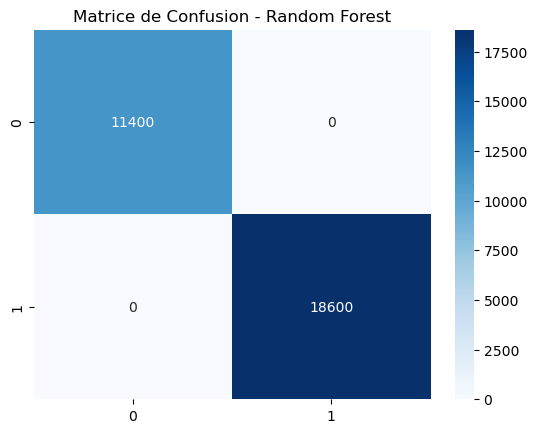

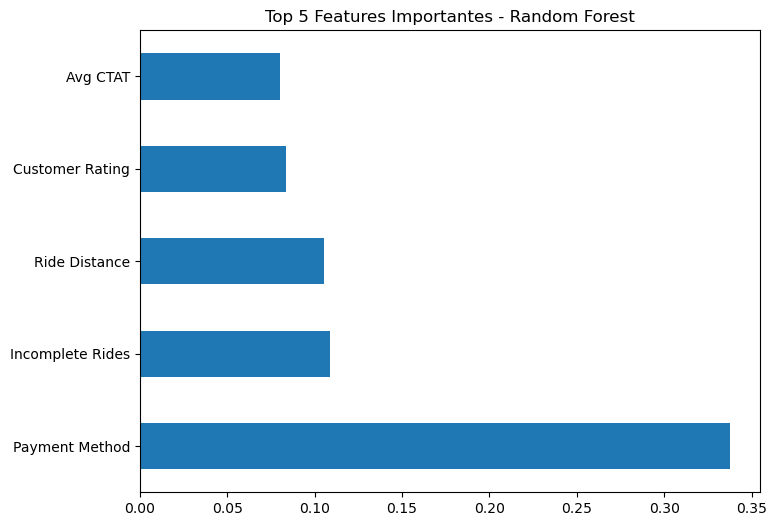

In [39]:
# Entraînement
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Prédictions
y_pred_rf = rf.predict(X_test)

# Évaluation
print("=== Random Forest ===")
print(classification_report(y_test, y_pred_rf))

# Matrice de confusion
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Matrice de Confusion - Random Forest")
plt.show()

# Importance des features
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.nlargest(5).plot(kind='barh', figsize=(8,6))
plt.title("Top 5 Features Importantes - Random Forest")
plt.show()


**XGBoost**

C:\Anaconda\Lib\site-packages\xgboost\training.py:183: UserWarning: [10:08:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11400
           1       1.00      1.00      1.00     18600

    accuracy                           1.00     30000
   macro avg       1.00      1.00      1.00     30000
weighted avg       1.00      1.00      1.00     30000



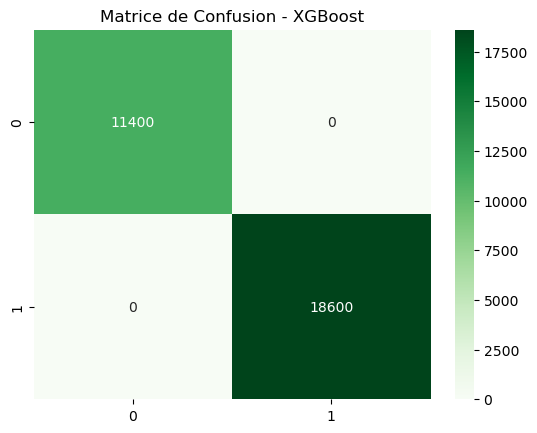

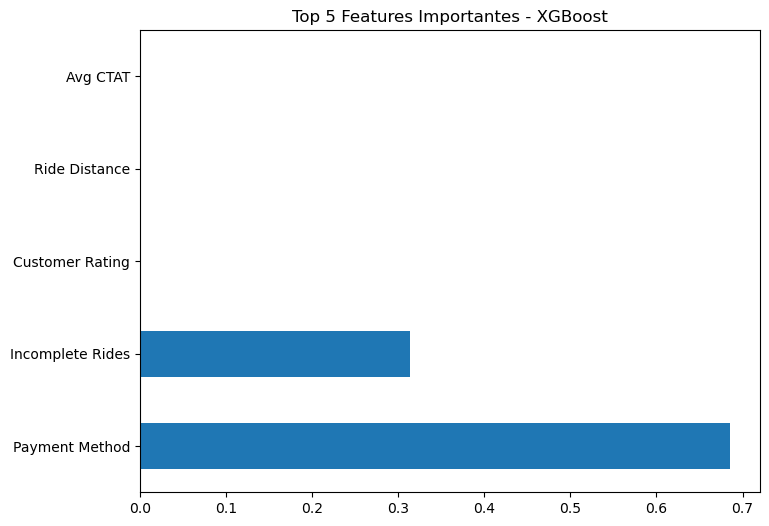

In [40]:


# Entraînement
xgb = XGBClassifier(
    n_estimators=300,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss',
    n_jobs=-1
)
xgb.fit(X_train, y_train)

# Prédictions
y_pred_xgb = xgb.predict(X_test)

# Évaluation
print("=== XGBoost ===")
print(classification_report(y_test, y_pred_xgb))

sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Greens")
plt.title("Matrice de Confusion - XGBoost")
plt.show()

# Importance des features
xgb_importances = pd.Series(xgb.feature_importances_, index=X.columns)
xgb_importances.nlargest(5).plot(kind='barh', figsize=(8,6))
plt.title("Top 5 Features Importantes - XGBoost")
plt.show()


**Comparaison des Modèles**

               Accuracy  Precision  Recall  F1-score
Random Forest       1.0        1.0     1.0       1.0
XGBoost             1.0        1.0     1.0       1.0


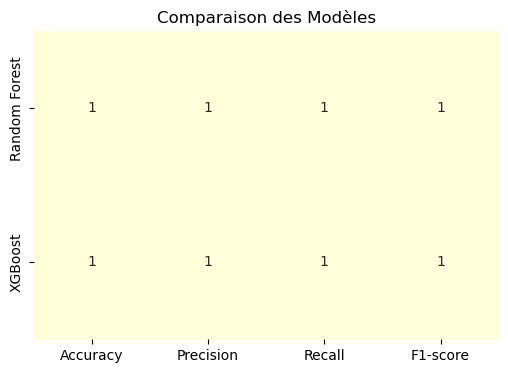

In [41]:

# Fonction pour calculer les métriques
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1-score": f1_score(y_true, y_pred)
    }

# Calcul des métriques
metrics_rf = get_metrics(y_test, y_pred_rf)
metrics_xgb = get_metrics(y_test, y_pred_xgb)

# Créer un DataFrame pour comparaison
comparison_df = pd.DataFrame([metrics_rf, metrics_xgb], index=["Random Forest", "XGBoost"])
comparison_df = comparison_df.round(4)

# Afficher le tableau
print(comparison_df)

# Optionnel : visualiser avec seaborn heatmap

plt.figure(figsize=(6,4))
sns.heatmap(comparison_df, annot=True, cmap="YlGnBu", cbar=False)
plt.title("Comparaison des Modèles")
plt.savefig('models.png')
plt.show()


**Interprétation des modèles**

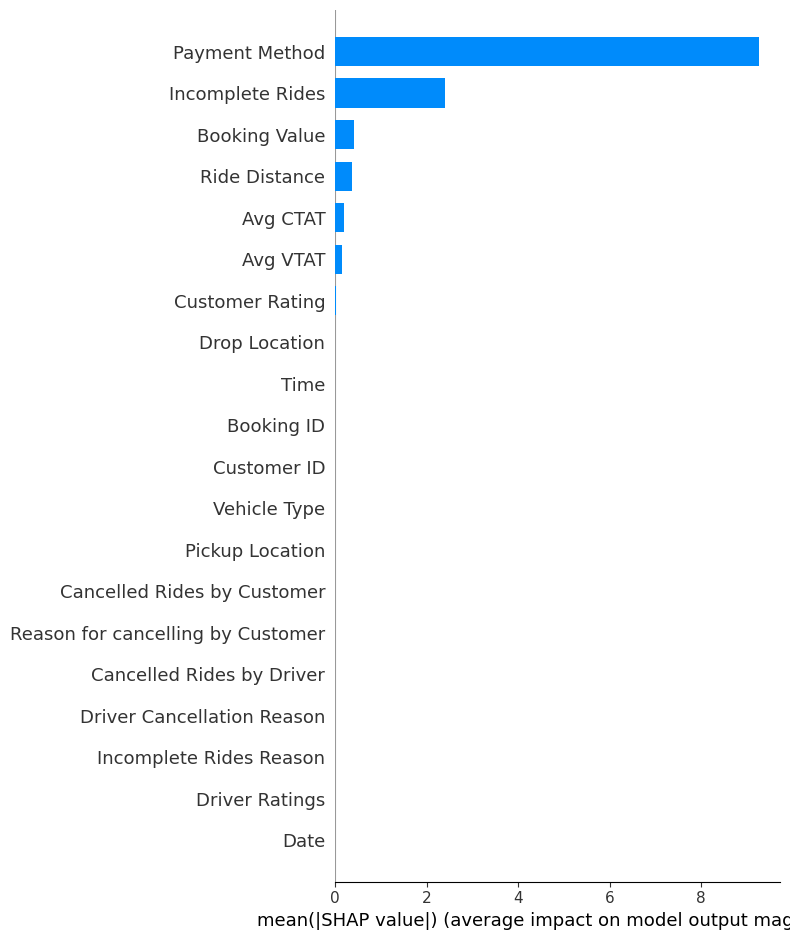

In [42]:
explainer_xgb = shap.TreeExplainer(xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test)

# Vérifier si shap_values_xgb est une liste (multi-classes) ou matrice
if isinstance(shap_values_xgb, list):
    # Binaire → prendre la classe positive
    shap.summary_plot(shap_values_xgb[1], X_test, plot_type="bar")
else:
    # Matrice unique
    shap.summary_plot(shap_values_xgb, X_test, plot_type="bar")


**Conclusion**

**Problématique** :
L’objectif était de prédire si une réservation serait complétée ou annulée afin de réduire les pertes financières et améliorer la satisfaction client et chauffeur.

Résultats clés :
Le modèle (Forêt Aléatoire / XGBoost) a identifié 6 variables principales influençant le statut des réservations :

Payment Method → La méthode de paiement a un fort impact sur les annulations.

Rides incomplètes (Incomplete Rides)

  -Un historique de courses incomplètes est un fort prédicteur de comportements futurs.

  -Un client qui annule souvent est plus susceptible d’annuler encore.

Ride Distance → Les trajets longs ou courts ont un effet significatif sur la complétion.

Booking Value → Les courses avec certains montants sont plus susceptibles d’être annulées.

avg ctat (Customer Rating) → Les clients avec des notes moyennes faibles peuvent être plus à risque d’annuler.

avg vtat (Driver Rating) → La note moyenne du chauffeur influence également la probabilité de complétion.

**Interprétation** :

Ces 6 features représentent les facteurs principaux que le modèle utilise pour prédire l’annulation ou la complétion d’une course.

Les autres features ont un impact moins significatif selon le SHAP bar plot.

🔹 Recommandations business

Optimiser la méthode de paiement :

Encourager les méthodes les moins associées aux annulations (ex. paiement en ligne plutôt qu’en espèces).

Réduire les courses incomplètes avec des pénalités douces ou des récompenses de fidélité.

Gestion des trajets :

Adapter la disponibilité des véhicules selon la distance : trajets très longs ou très courts pourraient nécessiter une attention particulière.

Focus sur la valeur de la réservation :

Pour les courses coûteuses, prévoir des confirmations supplémentaires ou des incentives pour éviter les annulations.

Suivi des notes client et chauffeur :

Les clients ou chauffeurs avec des notes faibles pourraient être ciblés pour des interventions préventives : communication proactive, récompenses pour fiabilité, etc.